In [11]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import os
import pyopencl
import datetime

#Finally, import our simulator
from SWESimulators import FBL, CTCS, DataOutput

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
from SWESimulators import FBL, CTCS, LxF, FORCE, HLL, HLL2, KP07, CDKLM16, DataOutput, PlotHelper, Common

In [12]:
#Make sure we get compiler output from OpenCL
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

#Set which CL device to use, and disable kernel caching
os.environ["PYOPENCL_CTX"] = "1"
os.environ["CUDA_CACHE_DISABLE"] = "1"

#Create OpenCL context
cl_ctx = pyopencl.create_some_context()
print "Using ", cl_ctx.devices[0].name

Using  GeForce 840M


In [13]:
def gen_testdataset(nx, ny, dx, dy, x0, y0):
    #Generate coordinates for each point
    x_coords = np.linspace(0, (nx-1)*dx, nx)
    y_coords = np.linspace(0, (ny-1)*dy, ny)

    #Generate the mesh of points
    x, y = np.meshgrid(x_coords, y_coords)

    #Generate our vector field
    x_vec = x - x0
    y_vec = y - y0
    r = np.sqrt(x_vec*x_vec + y_vec*y_vec)
    vx, vy = (-y_vec, x_vec) / (r*r+1.0)
    
    return x_coords, y_coords, vx, vy

(0.0, 500.0, 0.0, 500.0)

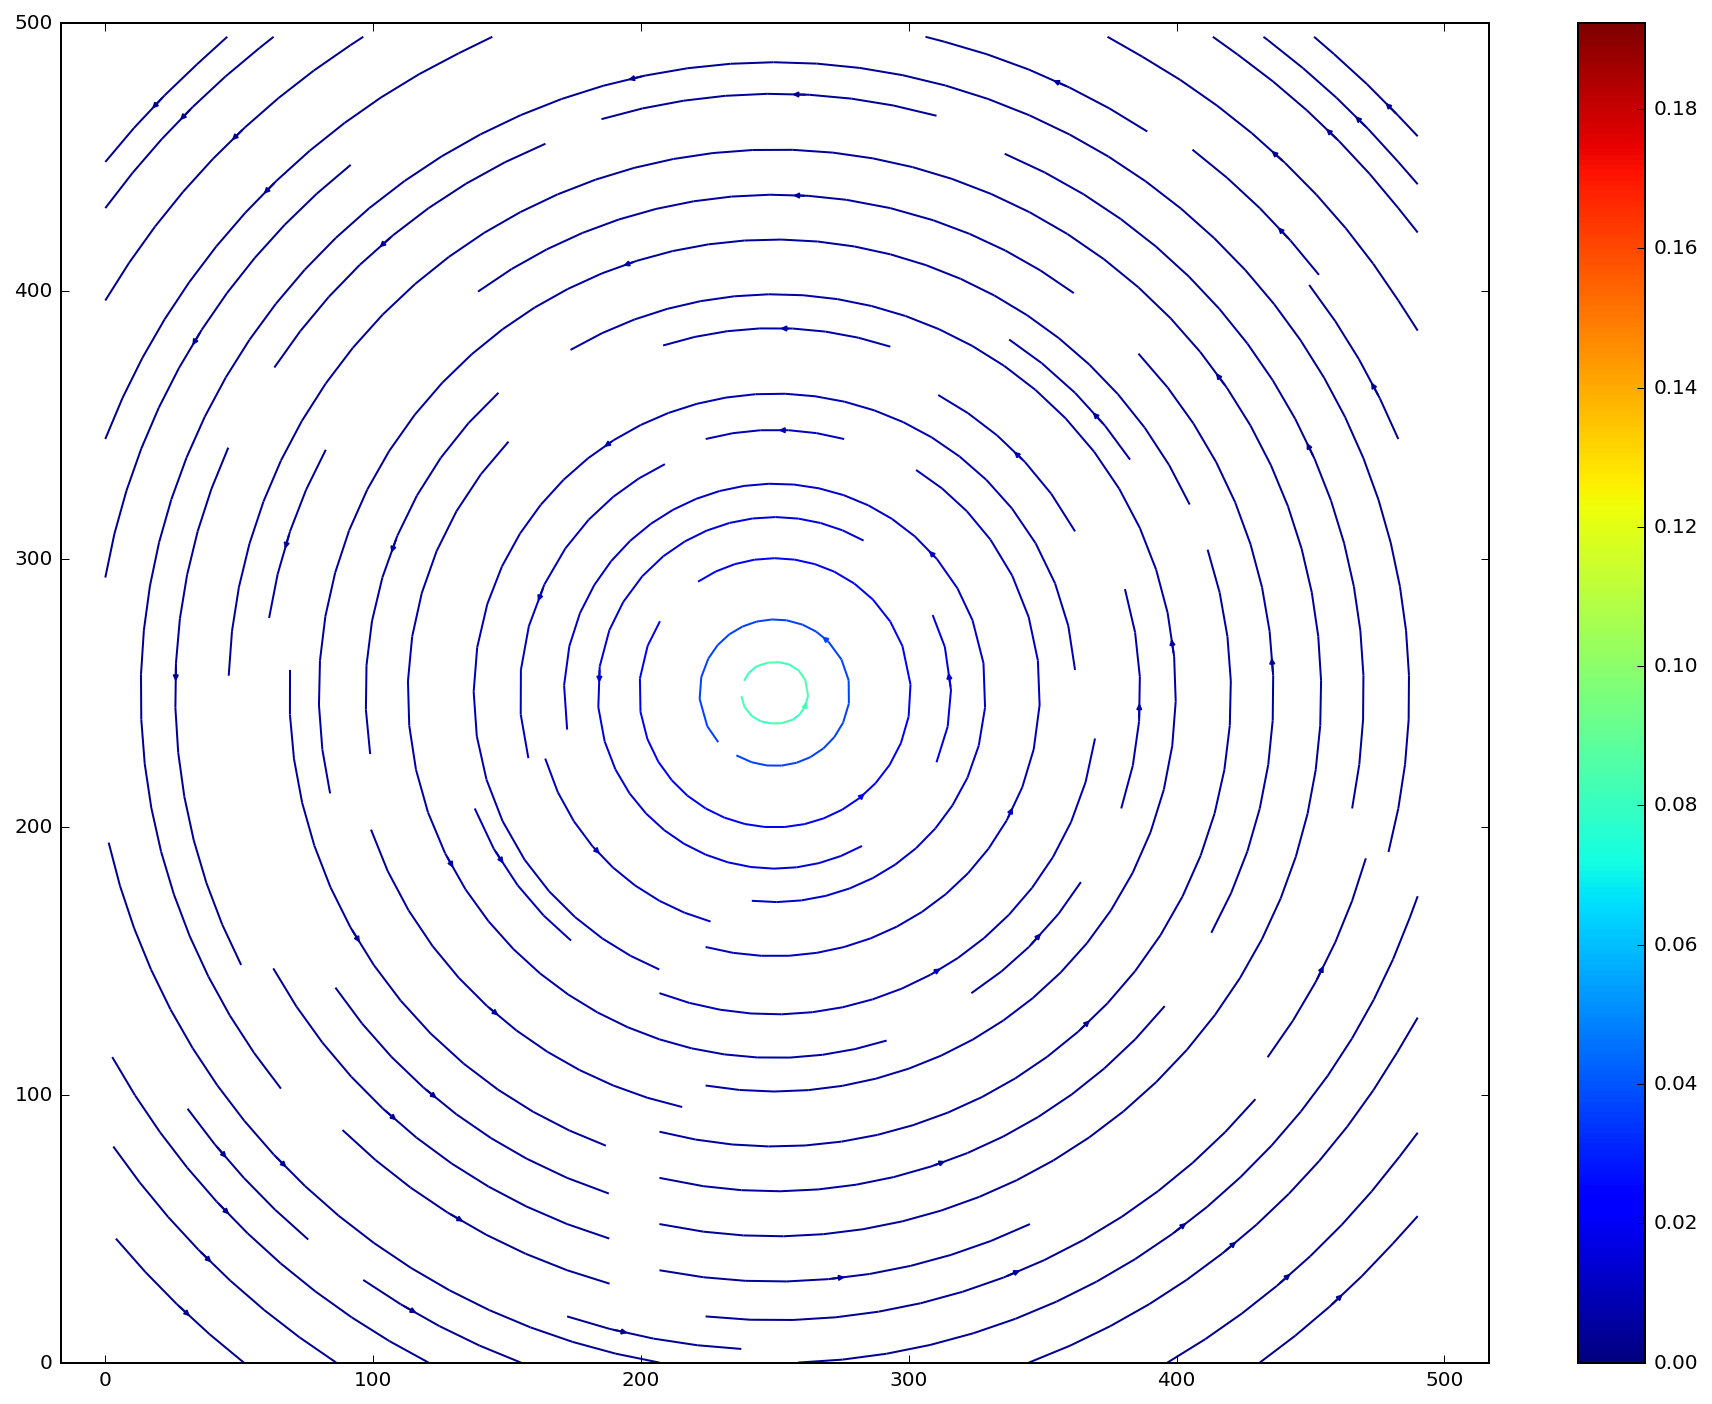

In [14]:
nx = 50
ny = 100

dx = 10
dy = 5

x0 = (nx/2.0)*dx
y0 = (ny/2.0)*dy

x_coords, y_coords, vx, vy = gen_testdataset(nx, ny, dx, dy, x0, y0)

#Plot our vector field
v = np.sqrt(vx*vx + vy*vy)
plt.figure()
plt.streamplot(x_coords, y_coords, vx, vy, color=v)
plt.colorbar()
plt.axis('equal')

In [21]:
"""
Bilinearly interpolates p(x, y) at the point x0, y0
x and y are 1d arrays with x and y coordintes of 
p, which is a 2d array of values
"""
def bilinear_interpolation(x0, y0, x, y, p):    
    #First, find the cell we are within
    if (x0 <= x[0]): #Extrapolate left
        ip = 1
    elif(x0 >= x[-1]): #Extrapolate right
        ip = len(x) - 1
    else: # Interpolate
        try:
            ip = np.where(x0 < x)[0][0]
        except:
            print x0
            print x
    
    if (y0 <=y[0]):
        jp = 0
    elif(y0 >= y[-1]):
        jp = len(y) - 1
    else:
        try:
            jp = np.where(y0 < y)[0][0]    
        except:
            print y0
            print y
    
    #Clamp to avoid out of bounds
    ip = min(max(1, ip), len(x) - 1)
    jp = min(max(1, jp), len(y) - 1)
    i = ip-1
    j = jp-1

    #Find how far into the cell we are
    ti = (x0 - x[i]) / (x[ip] - x[i])
    tj = (y0 - y[j]) / (y[jp] - y[j])

    #Evaluate the bilinear function
    p0 = (1.0-ti)*p[j , i] + ti*p[j , i+1]
    p1 = (1.0-ti)*p[jp, i] + ti*p[jp, i+1]
    p2 = (1.0-tj)*p0 + tj*p1
    
    return p2





"""
Trilinearly interpolates p(x, y, t) at the point x0, y0, t0
x and y are 1d arrays with x and y coordintes of 
p, which is a 2d array of values
"""
def trilinear_interpolation(x0, y0, t0, x, y, p0, p1):
    #First, find the cell we are within
    if (x0 <= x[0]): #Extrapolate left
        ip = 1
    elif(x0 >= x[-1]): #Extrapolate right
        ip = len(x) - 1
    else: # Interpolate
        try:
            ip = np.where(x0 < x)[0][0]
        except:
            print x0
            print x
    
    if (y0 <=y[0]):
        jp = 0
    elif(y0 >= y[-1]):
        jp = len(y) - 1
    else:
        try:
            jp = np.where(y0 < y)[0][0]    
        except:
            print y0
            print y
    
    #Clamp to avoid out of bounds
    ip = min(max(1, ip), len(x) - 1)
    jp = min(max(1, jp), len(y) - 1)
    i = ip-1
    j = jp-1

    #Find how far into the cell we are
    ti = (x0 - x[i]) / (x[ip] - x[i])
    tj = (y0 - y[j]) / (y[jp] - y[j])

    #Evaluate the bilinear function at p0
    p00 = (1.0-ti)*p0[j , i] + ti*p0[j , ip]
    p01 = (1.0-ti)*p0[jp, i] + ti*p0[jp, ip]
    p02 = (1.0-tj)*p00 + tj*p01
    
    #Evaluate the bilinear function at p1
    p10 = (1.0-ti)*p1[j , i] + ti*p1[j , ip]
    p11 = (1.0-ti)*p1[jp, i] + ti*p1[jp, ip]
    p12 = (1.0-tj)*p10 + tj*p11
    
    #Evaluate linear function between p02 and p12
    p22 = (1.0-t0)*p02 + t0*p12
    
    return p22

"""
Performs ODE integration using the seed point x0, y0 for a time t
x and y are 1d vectors of the x and y coordinates of 
vx and vy, which are 2d arrays with the respective velocities
"""
def rk2_ode(x0, y0, t, dt, x, y, vx0, vy0, vx1=None, vy1=None):
    nt = int(t / float(dt))+1
    
    u = np.zeros(nt)
    v = np.zeros(nt)
    
    u[0] = x0
    v[0] = y0
    
    
    for k in range(1, nt):
        #First halfstep
        if (vx1 != None and vy1 != None):
            t0 = k/float(nt)
            s1 = trilinear_interpolation(u[k-1], v[k-1], t0, x, y, vx0, vx1)
            t1 = trilinear_interpolation(u[k-1], v[k-1], t0, x, y, vy0, vy1)
        else:
            s1 = bilinear_interpolation(u[k-1], v[k-1], x, y, vx0)
            t1 = bilinear_interpolation(u[k-1], v[k-1], x, y, vy0)
        u1 = u[k-1] + dt*s1
        v1 = v[k-1] + dt*t1
                
        #Second halfstep
        if (vx1 != None and vy1 != None):
            t1 = (k+1)/float(nt)
            s2 = trilinear_interpolation(u1, v1, t1, x, y, vx0, vx1)
            t2 = trilinear_interpolation(u1, v1, t1, x, y, vy0, vy1)
        else:
            s2 = bilinear_interpolation(u1, v1, x, y, vx)
            t2 = bilinear_interpolation(u1, v1, x, y, vy)
        u2 = u1 + dt*s2
        v2 = v1 + dt*t2
        
        #Merge the two halfsteps
        u[k] = 0.5*(u[k-1] + u2)
        v[k] = 0.5*(v[k-1] + v2)
        
        #Clamp output to be within the domain
        u[k] = max(0, min(u[k], max(x)))
        v[k] = max(0, min(v[k], max(y)))
        
        
    return u, v

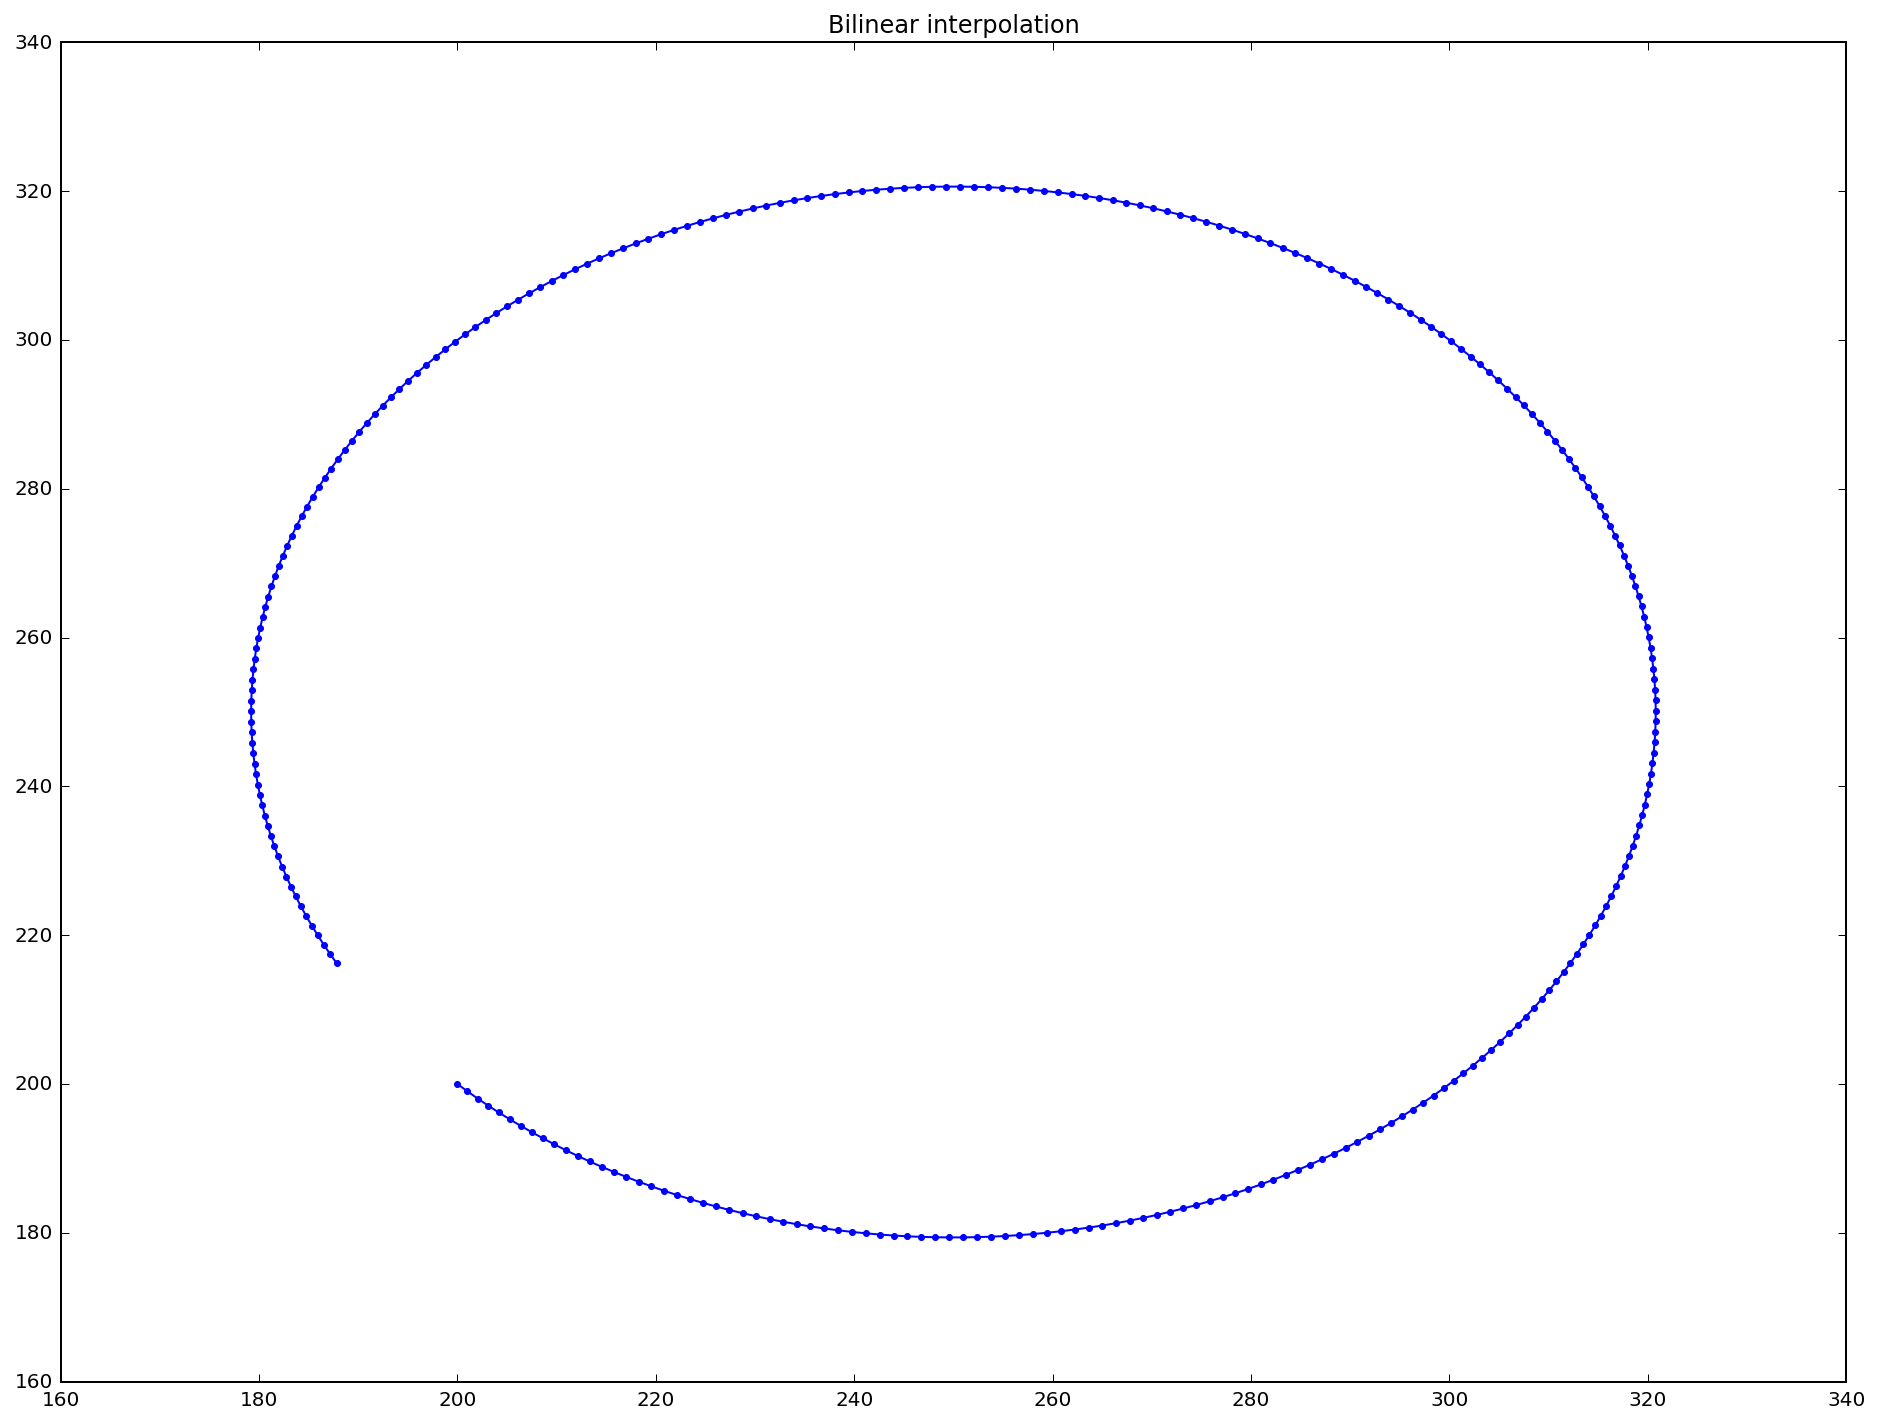

In [27]:
u, v = rk2_ode(200, 200, 30000, 100, x_coords, y_coords, vx, vy)

plt.plot(u, v, '.-')
plt.title('Bilinear interpolation')

C:\Users\anbro\AppData\Local\Enthought\Canopy32\User\lib\site-packages\ipykernel\__main__.py:122: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\anbro\AppData\Local\Enthought\Canopy32\User\lib\site-packages\ipykernel\__main__.py:133: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


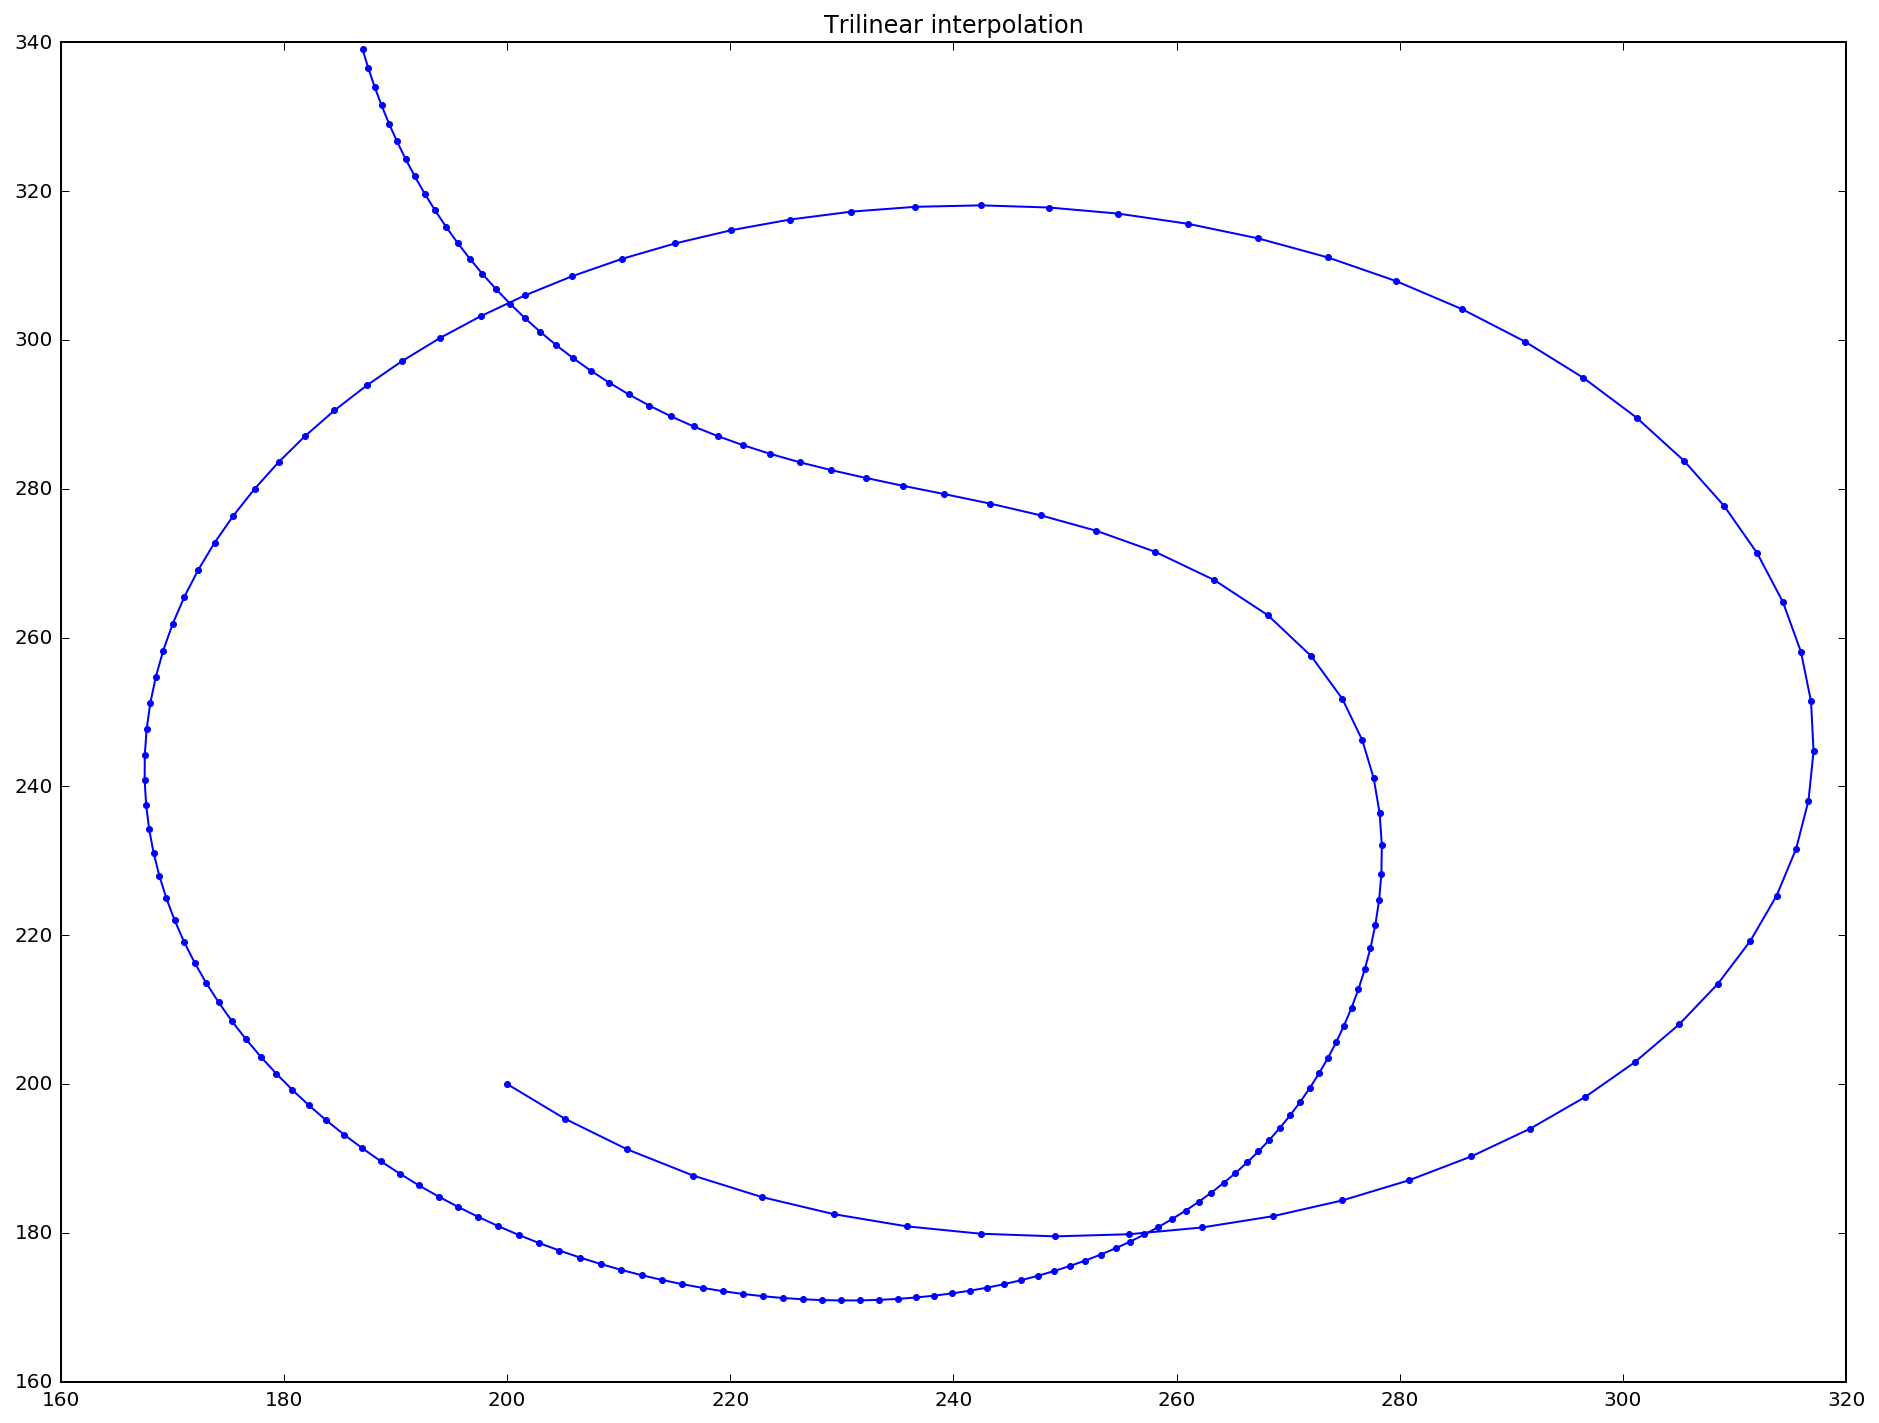

In [31]:
x_coords, y_coords, vx1, vy1 = gen_testdataset(nx, ny, dx, dy, x0*1.5, y0*1.5)

u, v = rk2_ode(200, 200, 100000, 500, x_coords, y_coords, vx, vy, -vx1, -vy1)

plt.plot(u, v, '.-')
plt.title('Trilinear interpolation')

In [32]:
#Centered in time, centered in space
nx = 50
ny = 25

dx = 20.0*1000
dy = 20.0*1000

dt = 90.0
g = 9.81
f = 0.00012
r = 0.0024
A = 5

wind_type = 0
wind_tau0 = 0.1
wind_rho = 1025.0
wind_alpha = 0.000005

h0 = np.ones((ny+2, nx+2), dtype=np.float32, order='C') * 50.0;
eta0 = np.zeros((ny+2, nx+2), dtype=np.float32, order='C');
u0 = np.zeros((ny+2, nx+1), dtype=np.float32, order='C');
v0 = np.zeros((ny+1, nx+2), dtype=np.float32, order='C');

            
#Initialize simulator
reload(CTCS)

wind_stress = Common.WindStressParams(wind_type, \
                wind_tau0, wind_rho, wind_alpha)
sim = CTCS.CTCS(cl_ctx, \
                h0, eta0, u0, v0, \
                nx, ny, \
                dx, dy, dt, \
                g, f, r, A, \
                wind_stress)


#Run simulation
num_iterations=96
data = [[eta0, u0, v0]]
for i in range(num_iterations):
    timestep = 3600.0
    t = sim.step(timestep)
    eta, u, v = sim.download()
    data.append([eta, u, v])

In [33]:
def calculate_velocity(h, eta, hu, hv):
    H = h + eta
    vx = 0.5*(hu[1:-1,1:] + hu[1:-1,:-1]) / (H[1:-1,1:-1])
    vy = 0.5*(hv[1:,1:-1] + hv[:-1,1:-1]) / (H[1:-1,1:-1])
    return vx, vy
    
    
    
    
ss = np.array([10*dx])
tt = np.array([10*dy])

#Calculate radius from center of bump for plotting
fig = plt.figure()

ax = fig.add_subplot(1, 3, 1)
p0 = plt.imshow(data[0][0][1:-1,1:-1].T, interpolation='nearest', origin='bottom', vmax=0.1, vmin=-0.1)
plt.axis('tight')
line1, = plt.plot(tt/dy, ss/dx, 'r-')
point1, = plt.plot(tt[-1]/dy, ss[-1]/dx, 'k*')
#plt.colorbar()

vx0, vy0 = calculate_velocity(h0, data[0][0], data[0][1], data[0][2])
ax = fig.add_subplot(1, 3, 3)
p1 = plt.imshow(vx0.T, interpolation='nearest', origin='bottom', vmax=0.05, vmin=-0.05)
plt.axis('tight')
line2, = plt.plot(tt/dy, ss/dx, 'r-')
point2, = plt.plot(tt[-1]/dy, ss[-1]/dx, 'k*')
plt.colorbar()

ax = fig.add_subplot(1, 3, 2)
p2 = plt.imshow(vy0.T, interpolation='nearest', origin='bottom', vmax=0.05, vmin=-0.05)
plt.axis('tight')
line3, = plt.plot(tt/dy, ss/dx, 'r-')
point3, = plt.plot(tt[-1]/dy, ss[-1]/dx, 'k*')
plt.colorbar()




def animate(i):
    
    global ss, tt, u0, v0
    
    eta1, u1, v1 = data[i]
    
    vx0, vy0 = calculate_velocity(h0, eta0, u0, v0)
    vx1, vy1 = calculate_velocity(h0, eta1, u1, v1)
    
    u0, v0 = u1, v1
    
    if (i > 5):
        x = np.linspace(0, (nx-1), nx)*dx
        y = np.linspace(0, (ny-1), ny)*dy
        ss1, tt1 = rk2_ode(ss[-1], tt[-1], timestep*1000, timestep*1000, x, y, vx0, vy0, vx1, vy1)
        ss = np.concatenate((ss, ss1))
        tt = np.concatenate((tt, tt1))


    fig.suptitle("CTCS " + str(i) + " ", fontsize=18)
    
    #fig.add_subplot(1, 3, 1)
    p0.set_data(eta1[1:-1,1:-1].T)
    line1.set_ydata(ss/dx)
    line1.set_xdata(tt/dy)
    point1.set_ydata(ss[-1]/dx)
    point1.set_xdata(tt[-1]/dy)
    
    #fig.add_subplot(1, 3, 2)
    p1.set_data(vx1.T)
    line2.set_ydata(ss/dx)
    line2.set_xdata(tt/dy)
    point2.set_ydata(ss[-1]/dx)
    point2.set_xdata(tt[-1]/dy)
    
    #fig.add_subplot(1, 3, 3)
    p2.set_data(vy1.T)
    line3.set_ydata(ss/dx)
    line3.set_xdata(tt/dy)
    point3.set_ydata(ss[-1]/dx)
    point3.set_xdata(tt[-1]/dy)
    
    plt.draw()
    



    
anim = animation.FuncAnimation(fig, animate, range(num_iterations), interval=100)
plt.close(anim._fig)
anim

C:\Users\anbro\AppData\Local\Enthought\Canopy32\User\lib\site-packages\ipykernel\__main__.py:122: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\anbro\AppData\Local\Enthought\Canopy32\User\lib\site-packages\ipykernel\__main__.py:133: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
